In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
import os
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
from torchvision.models import vgg16, resnet50
from torchvision.models import VGG16_Weights, ResNet50_Weights 
from torch import optim
from torchsummary import summary

# Parameters Setting

In [2]:
root = "/content/drive/MyDrive/Colab Notebooks/graduates class/Application of Structure Machine Learning/implement_(1)/fire dataset"
train_path = os.path.join(root, "train")
test_path = os.path.join(root, "test")
batch_size = 32
epochs = 10


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("cuda" if torch.cuda.is_available() else "cpu")

cuda


# Dataset

## customized dataset

In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# training data
train_ds = ImageFolder(train_path, transform=train_transforms)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# testing data
test_ds = ImageFolder(test_path, transform=test_transforms)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


## observe dataset

In [7]:
# training set
train_size = len(train_ds)
train_lbl_0, train_lbl_1 = 0, 0
for i in range(0, train_size):
  if train_ds[i][1] == 0: # label is 0
    train_lbl_0 += 1
  else:           # label is 1
    train_lbl_1 += 1

# testing set
test_size = len(test_ds)
test_lbl_0, test_lbl_1 = 0, 0
for i in range(0, test_size):
  if test_ds[i][1] == 0: # label is 0
    test_lbl_0 += 1
  else:           # label is 1
    test_lbl_1 += 1

fire_col = [train_lbl_1, test_lbl_1, train_lbl_1+test_lbl_1]
nonfire_col = [train_lbl_0, test_lbl_0, train_lbl_0+test_lbl_0]
ratio_col = [f"{(train_lbl_0/train_lbl_1):.1f}", f"{(test_lbl_0/test_lbl_1):.1f}", train_lbl_0+train_lbl_1+test_lbl_0+test_lbl_1]

ds_form = pd.DataFrame({"non fire(label 0)":nonfire_col,
             "fire(label 1)":fire_col,
             "imbalanced":ratio_col},
             index=["train", "test", "total"])
ds_form


,non fire(label 0),fire(label 1),imbalanced
train,490,59,8.3
test,51,51,1.0
total,541,110,651


# Observe and Modify VGG-16

## origianl

In [ ]:
# download VGG-16 model
vgg = copy.deepcopy(vgg16(weights=VGG16_Weights.DEFAULT))
vgg.classifier[-1] = nn.Linear(4096, 2)

# observe original VGG-16
# watch that the output of last layer in classifier is 2 
for name, layer in vgg.named_children():
  print(name)
  print(layer)

In [9]:
# freeze its parameter in feature extraction stage
for param in vgg.features.parameters():
  param.requires_grad = False

## modified

In [ ]:
# download another VGG-16 model
vgg_mod = copy.deepcopy(vgg16(weights=VGG16_Weights.DEFAULT))

# modified layer
# output size of avgpool is [512, 7, 7]
# so in_features of first nn.Linear is 512*7*7
# on other hand, VGG-16 have flatten implicitly, so don't add flatten
vgg_layer = nn.Sequential(nn.Linear(512*7*7, 4096),
              nn.ReLU(inplace=True),
              nn.Dropout(),
              nn.Linear(4096, 4096),
              nn.ReLU(inplace=True),
              nn.Dropout(),
              nn.Linear(4096, 4096),
              nn.ReLU(inplace=True),
              nn.Dropout(),
              nn.Linear(4096, 2)
              )
vgg_mod.classifier = vgg_layer

# observe modified VGG-16
# watch its classifier layer
for named, layer in vgg_mod.named_children():
  print(named)
  print(layer)

In [11]:
# freeze all parameters in feature extraction stage
for param in vgg_mod.features.parameters():
  param.requires_grad = False

# Observe and Modify ResNet-50

## original

In [ ]:
# download ResNet-50 and modify
res = copy.deepcopy(resnet50(weights=ResNet50_Weights.DEFAULT))

# freeze all parameters
for params in res.parameters():
  params.requires_grad = False

# modify ResNet-50
# observe modified ResNet-50
# watch out_features of its last linear layer
res.fc = nn.Linear(2048, 2)
for name, layer in res.named_children():
  print(name)
  print(layer)

## modified

In [ ]:
# dowmload another ResNet-50
res_mod = copy.deepcopy(resnet50(weights=ResNet50_Weights.DEFAULT))

# freeze all parameters
for param in res_mod.parameters():
  param.requires_grad = False

res_layer = nn.Sequential(nn.Linear(2048, 4096),
              nn.ReLU(inplace=True),
              nn.Dropout(),
              nn.Linear(4096, 2)
              )
res_mod.fc = res_layer

# observe modified ResNet-50
# watch its fc layer
for name, layer in res_mod.named_children():
  print(name)
  print(layer)

# Define Training Function

In [14]:
def train_model(model, criterion, optimizer, epochs):
  since = time.time()

  best_model_parameters = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_loss = float("inf")

  acc_list = []
  loss_list = []

  model.train()
  for epoch in range(1, epochs+1):
    print(f"Epochs: {epoch}/{epochs}")
    print("-"*15)

    batch_loss = 0.0
    corrects = 0

    for data, label in train_dl:
      data, label = data.to(device), label.to(device)

      optimizer.zero_grad()  # zero gradient

      output = model(data)
      _, pred = torch.max(output, 1)

      loss = criterion(output, label) # loss
      loss.backward()          # back propagation
      optimizer.step()          # update parameters
      
      
      batch_loss += loss.item() * data.size(0)  # total loss of one batch
      corrects += torch.sum(pred == label.data)  # total correct of one batch
    
    # save each epoch loss and acc
    epoch_loss = batch_loss / len(train_dl.dataset)
    epoch_acc = corrects.float() / len(train_dl.dataset)
    loss_list.append(epoch_loss)
    acc_list.append(epoch_acc.item())

    print(f"Loss: {epoch_loss:.5f}")
    print(f"Acc: {epoch_acc:.5f}")
    print()

    # save best parameters
    if epoch_loss < best_loss:
      best_loss = epoch_loss
      best_model_parameters = copy.deepcopy(model.state_dict())
    
  times = time.time() - since
  print(f"Training Complete !")
  print(f"times: {times//60} min {(times%60):.0f} sec")

  # save best model
  model.load_state_dict(best_model_parameters)

  return model, loss_list, acc_list


# Start Training

## original VGG-16

In [15]:
vgg = vgg.to(device)

optim_vgg = optim.Adam(vgg.parameters())
criterion = nn.CrossEntropyLoss()

vgg, vgg_loss, vgg_acc = train_model(model=vgg, criterion=criterion, optimizer=optim_vgg, epochs=epochs)


Epochs: 1/10
---------------
Loss: 0.66915
Acc: 0.90164

Epochs: 2/10
---------------
Loss: 0.28669
Acc: 0.96539

Epochs: 3/10
---------------
Loss: 0.21491
Acc: 0.97268

Epochs: 4/10
---------------
Loss: 0.01319
Acc: 0.99636

Epochs: 5/10
---------------
Loss: 0.00483
Acc: 0.99818

Epochs: 6/10
---------------
Loss: 0.24234
Acc: 0.99089

Epochs: 7/10
---------------
Loss: 0.20863
Acc: 0.99271

Epochs: 8/10
---------------
Loss: 0.16289
Acc: 0.99636

Epochs: 9/10
---------------
Loss: 0.48689
Acc: 0.99089

Epochs: 10/10
---------------
Loss: 1.87990
Acc: 0.98361

Training Complete !
times: 2.0 min 40 sec


## modified VGG-16

In [16]:
vgg_mod = vgg_mod.to(device)

optim_vgg_mod = optim.Adam(vgg_mod.parameters())
criterion = nn.CrossEntropyLoss()

vgg_mod, vgg_mod_loss, vgg_mod_acc = train_model(model=vgg_mod, criterion=criterion, optimizer=optim_vgg_mod, epochs=epochs)


Epochs: 1/10
---------------
Loss: 1.28469
Acc: 0.88707

Epochs: 2/10
---------------
Loss: 0.27719
Acc: 0.95993

Epochs: 3/10
---------------
Loss: 0.14426
Acc: 0.98725

Epochs: 4/10
---------------
Loss: 0.14699
Acc: 0.97814

Epochs: 5/10
---------------
Loss: 0.19700
Acc: 0.98361

Epochs: 6/10
---------------
Loss: 0.34629
Acc: 0.98725

Epochs: 7/10
---------------
Loss: 0.07455
Acc: 0.98725

Epochs: 8/10
---------------
Loss: 0.00326
Acc: 0.99818

Epochs: 9/10
---------------
Loss: 0.12451
Acc: 0.99271

Epochs: 10/10
---------------
Loss: 0.27313
Acc: 0.98543

Training Complete !
times: 2.0 min 27 sec


## original ResNet-50

In [17]:
res = res.to(device)

optim_res = optim.Adam(res.parameters())
criterion = nn.CrossEntropyLoss()

res, res_loss, res_acc = train_model(model=res, criterion=criterion, optimizer=optim_res, epochs=epochs)


Epochs: 1/10
---------------
Loss: 0.40625
Acc: 0.85610

Epochs: 2/10
---------------
Loss: 0.23927
Acc: 0.90893

Epochs: 3/10
---------------
Loss: 0.14407
Acc: 0.95811

Epochs: 4/10
---------------
Loss: 0.12381
Acc: 0.95993

Epochs: 5/10
---------------
Loss: 0.10115
Acc: 0.97268

Epochs: 6/10
---------------
Loss: 0.08240
Acc: 0.98543

Epochs: 7/10
---------------
Loss: 0.07171
Acc: 0.98179

Epochs: 8/10
---------------
Loss: 0.06195
Acc: 0.98725

Epochs: 9/10
---------------
Loss: 0.06423
Acc: 0.98543

Epochs: 10/10
---------------
Loss: 0.05123
Acc: 0.99271

Training Complete !
times: 2.0 min 6 sec


## modified ResNet-50

In [18]:
res_mod = res_mod.to(device)

optim_res_mod = optim.Adam(res_mod.parameters())
criterion = nn.CrossEntropyLoss()

res_mod, res_mod_loss, res_mod_acc = train_model(model=res_mod, criterion=criterion, optimizer=optim_res_mod, epochs=epochs)


Epochs: 1/10
---------------
Loss: 0.32046
Acc: 0.89800

Epochs: 2/10
---------------
Loss: 0.09561
Acc: 0.97086

Epochs: 3/10
---------------
Loss: 0.03930
Acc: 0.98907

Epochs: 4/10
---------------
Loss: 0.02567
Acc: 0.99089

Epochs: 5/10
---------------
Loss: 0.04203
Acc: 0.98725

Epochs: 6/10
---------------
Loss: 0.00760
Acc: 1.00000

Epochs: 7/10
---------------
Loss: 0.00565
Acc: 1.00000

Epochs: 8/10
---------------
Loss: 0.00314
Acc: 1.00000

Epochs: 9/10
---------------
Loss: 0.00485
Acc: 0.99818

Epochs: 10/10
---------------
Loss: 0.00222
Acc: 1.00000

Training Complete !
times: 2.0 min 7 sec


# Visualize Loss Value

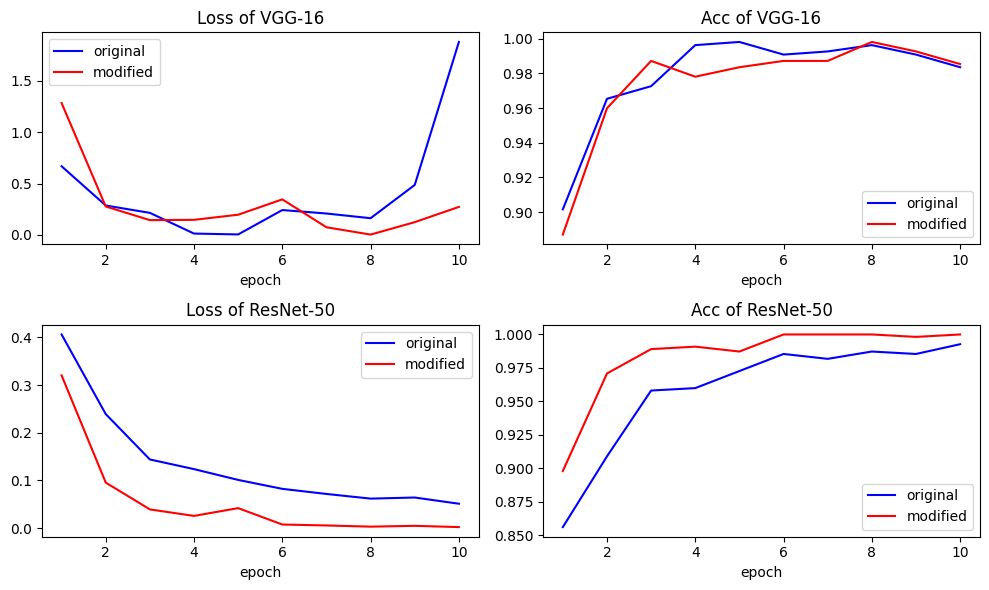

In [24]:
loss = [vgg_loss, vgg_mod_loss, res_loss, res_mod_loss]
acc =  [vgg_acc, vgg_mod_acc, res_acc, res_mod_acc]
title = ["Loss of VGG-16", "Acc of VGG-16", "Loss of ResNet-50", "Acc of ResNet-50"]

plt.figure(figsize=(10, 6))

def visualize_loss(loss, acc, title):
  for i in range(0, 2): # control row
    for j in range(0, 2):
      if j == 0: # first column
       ax = plt.subplot(2, 2, 2*i+j+1)
       ax.plot(range(1, epochs+1), loss[2*i+j], color="blue", label="original")
       ax.plot(range(1, epochs+1), loss[2*i+j+1], color="red", label="modified")
       ax.set_xlabel("epoch")
       ax.set_title(title[2*i+j])
       ax.legend()
      else:       # second column
       ax = plt.subplot(2, 2, 2*i+j+1)
       ax.plot(range(1, epochs+1), acc[2*i], color="blue", label="original")
       ax.plot(range(1, epochs+1), acc[2*i+j], color="red", label="modified")
       ax.set_xlabel("epoch")
       ax.set_title(title[2*i+j])
       ax.legend()
  plt.tight_layout()

visualize_loss(loss, acc, title)


# Define Testing Function

In [25]:
def test_model(model):
  was_training = model.training # save current mode
  acc = 0.0
  correct = 0
    
  model.eval()
  with torch.no_grad():
    for data, label in test_dl:
      data, label = data.to(device), label.to(device)
             
      output = model(data)
      _, pred = torch.max(output, 1)
      correct += torch.sum(pred == label.data)
        
  acc = correct.float() / len(test_dl.dataset)
  model.train(mode=was_training) # back to previous mode
    
  return acc

## testing

In [27]:
test_vgg_acc = test_model(vgg)
test_vgg_mod_acc = test_model(vgg_mod)
test_res_acc = test_model(res)
test_res_mod_acc = test_model(res_mod)

print(f"Acc of original VGG-16: {test_vgg_acc}")
print(f"Acc of modified VGG-16: {test_vgg_mod_acc}")
print(f"Acc of original ResNet-50: {test_res_acc}")
print(f"Acc of modified ResNet-50: {test_res_mod_acc}")


Acc of original VGG-16: 0.8333333730697632
Acc of modified VGG-16: 0.9215686321258545
Acc of original ResNet-50: 0.9117647409439087
Acc of modified ResNet-50: 0.9509804248809814


## save model

In [29]:
def save_model(model, filename_model, filename_param, path):
  model_path = path + filename_model
  param_path = path + filename_param
  torch.save(model, model_path)        # save all model
  torch.save(model.state_dict(), param_path)  # save parameters
  

In [30]:
save_root = "/content/drive/MyDrive/Colab Notebooks/graduates class/Application of Structure Machine Learning/implement_(1)/"

save_model(vgg_mod, "VGG-16_mod_model.pt", "VGG-16_mod_param.pth", save_root) # save vgg-16 and its param
save_model(res_mod, "Res-50_mod_model.pt", "Res-50_mod_param.pth", save_root) # save resnet-50 and its param